In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

First few rows of dataset:
         Income  Age  Dependents     Occupation City_Tier          Rent  \
0   44637.24964   49           0  Self_Employed    Tier_1  13391.174890   
1   26858.59659   34           2        Retired    Tier_2   5371.719318   
2   50367.60508   35           1        Student    Tier_3   7555.140763   
3  101455.60020   21           0  Self_Employed    Tier_3  15218.340040   
4   24875.28355   52           4   Professional    Tier_2   4975.056710   

   Loan_Repayment    Insurance     Groceries    Transport  ...  \
0        0.000000  2206.490129   6658.768341  2636.970696  ...   
1        0.000000   869.522617   2818.444460  1543.018778  ...   
2     4612.103386  2201.800050   6313.222081  3221.396403  ...   
3     6809.441427  4889.418087  14690.149360  7106.130005  ...   
4     3112.609398   635.907170   3034.329665  1276.155163  ...   

   Desired_Savings  Disposable_Income  Potential_Savings_Groceries  \
0      6200.537192       11265.627710                  

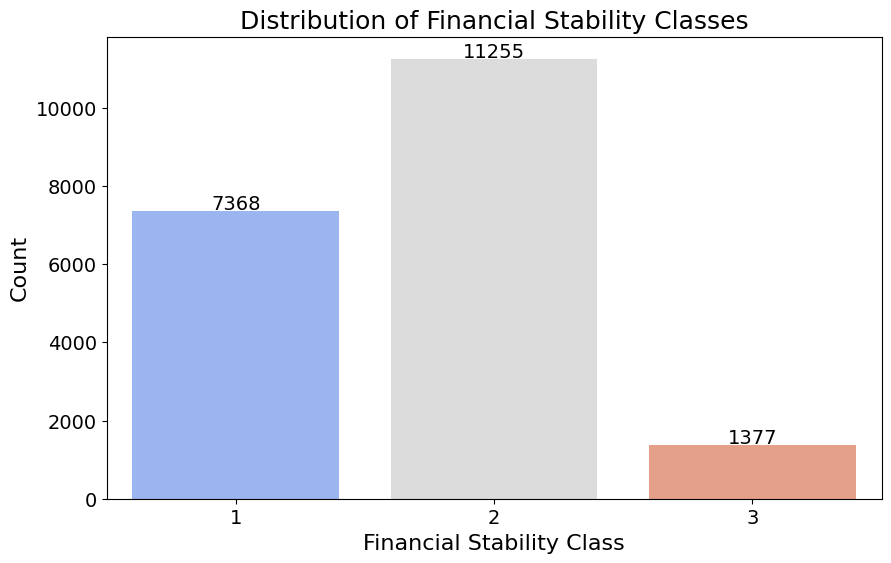

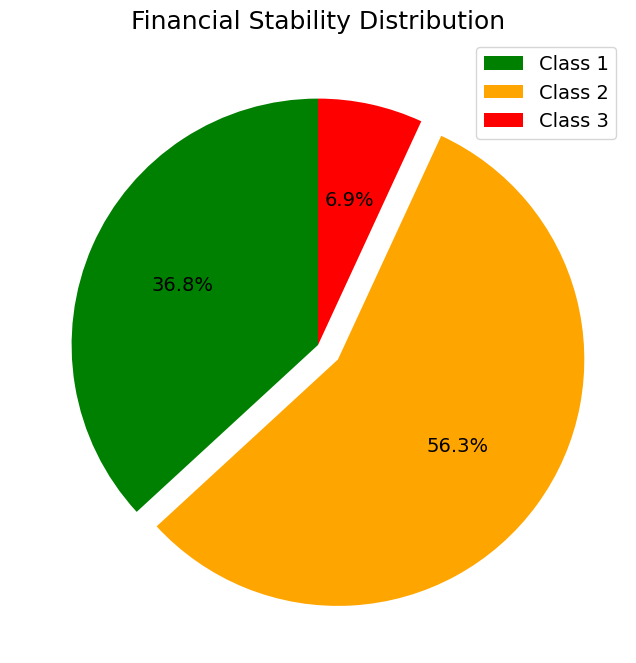

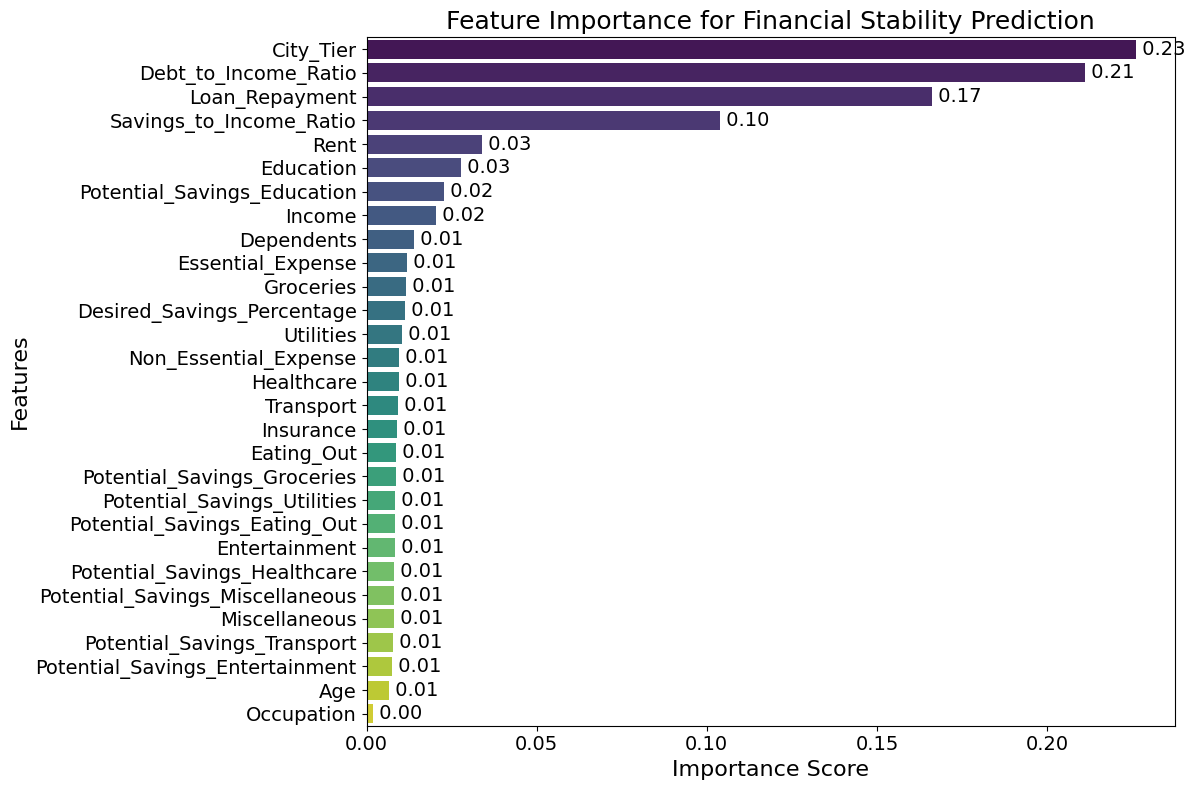

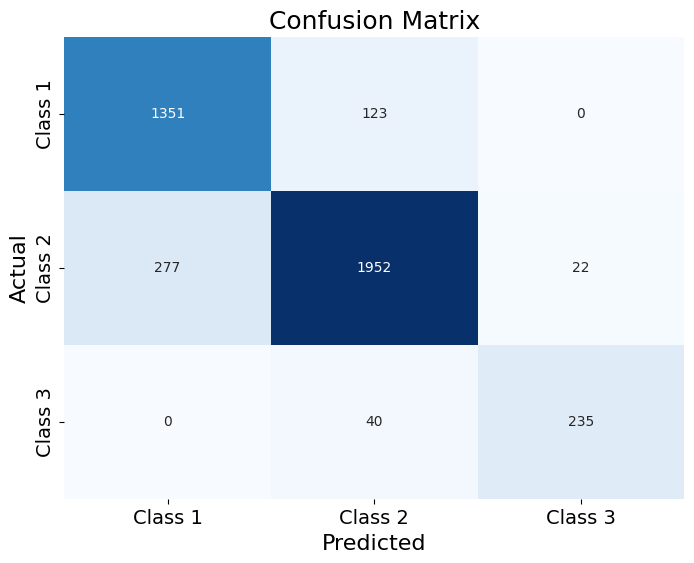

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

# Load dataset
csv_path = "/kaggle/input/indian-expense1/data1.csv"  # Update with your actual path
df = pd.read_csv(csv_path)

# Display first few rows
print("First few rows of dataset:")
print(df.head())

# Create new financial ratios
df["Debt_to_Income_Ratio"] = df["Loan_Repayment"] / df["Income"]
df["Savings_to_Income_Ratio"] = df["Desired_Savings"] / df["Income"]
df["Essential_Expense"] = df["Groceries"] + df["Transport"] + df["Utilities"] + df["Healthcare"]
df["Non_Essential_Expense"] = df["Eating_Out"] + df["Entertainment"] + df["Miscellaneous"]

# Define Financial Stability Classes
def classify_stability(row):
    if row["Disposable_Income"] > 0.3 * row["Income"] and row["Debt_to_Income_Ratio"] < 0.2:
        return 1  # Financially Stable
    elif row["Disposable_Income"] > 0.1 * row["Income"] and row["Debt_to_Income_Ratio"] < 0.4:
        return 2  # Moderately Stable
    else:
        return 3  # Financially Unstable

df["Financial_Stability"] = df.apply(classify_stability, axis=1)

# Encode categorical variables
df["Occupation"] = LabelEncoder().fit_transform(df["Occupation"])
df["City_Tier"] = LabelEncoder().fit_transform(df["City_Tier"])

# Define features and target
X = df.drop(columns=["Financial_Stability", "Disposable_Income", "Desired_Savings"])
y = df["Financial_Stability"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define hyperparameter grid for RandomForestClassifier
param_grid = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "class_weight": ["balanced"]
}

# Initialize RandomizedSearchCV
rf_tuner = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    random_state=42
)

# Fit the model
rf_tuner.fit(X_train, y_train)

# Get the best model
best_rf_model = rf_tuner.best_estimator_
print("Best Hyperparameters:", rf_tuner.best_params_)

# Predictions
y_pred_optimized = best_rf_model.predict(X_test)

# Evaluate performance
optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
print("Optimized Accuracy: {:.0f}%".format(optimized_accuracy * 100))
print("Classification Report:\n", classification_report(y_test, y_pred_optimized))

# ---- Enhanced Visualization ----

# 1. Bar Chart: Distribution of Financial Stability Classes
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="Financial_Stability", data=df, palette="coolwarm")
plt.title("Distribution of Financial Stability Classes", fontsize=18)
plt.xlabel("Financial Stability Class", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Annotate bars with counts
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', fontsize=14, color='black',
                xytext = (0, 5), textcoords = 'offset points')
plt.show()

# 2. Pie Chart: Percentage Distribution of Stability Classes
plt.figure(figsize=(8, 8))
counts = df["Financial_Stability"].value_counts().sort_index()
labels = [f'Class {i}' for i in counts.index]
# Explode the largest slice for emphasis
explode = [0.1 if count==max(counts) else 0 for count in counts]
plt.pie(counts, autopct="%1.1f%%", startangle=90, explode=explode, colors=["green", "orange", "red"], textprops={'fontsize': 14})
plt.title("Financial Stability Distribution", fontsize=18)
plt.legend(labels=labels, loc="best", fontsize=14)
plt.show()

# 3. Feature Importance for RandomForest
feature_names = X.columns
importance = best_rf_model.feature_importances_
# Create a dataframe for easier plotting and sorting
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Feature Importance for Financial Stability Prediction", fontsize=18)
plt.xlabel("Importance Score", fontsize=16)
plt.ylabel("Features", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Annotate bars with importance scores
for index, value in enumerate(importance_df["Importance"]):
    plt.text(value, index, f" {value:.2f}", va="center", fontsize=14)
plt.tight_layout()
plt.show()

# 4. Confusion Matrix: Model Performance
cm = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False)
plt.title("Confusion Matrix", fontsize=18)
plt.xlabel("Predicted", fontsize=16)
plt.ylabel("Actual", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
